# Interactive Mapping using Python and Bokeh 

**Author:** Rebecca Vandewalle rcv3@illinois.edu
<br>**Created:** 5-31-21

This notebook demonstrates how to create interactive maps using the bokeh library (https://docs.bokeh.org/en/latest/index.html).

## Contents
- [Introduction](#intro)
- [Installing Bokeh](#install)
- [Data used in the Notebook](#data)
- [Load Libraries and setup Bokeh](#load)
- [Map a Shapefile](#map_shp)
    - [Load Shapefiles](#load_shp)
    - [Edit Shapefiles for Plotting](#edit_shp)
    - [Set Up the Map](#set_up_map1)
- [A More Interactive Map](#more_interact)
    - [Load and Edit Movies Dataset](#load_movies)
    - [Create New Timeline Dataset](#create_tl_dataset)
    - [Set Up the Map](#set_up_map2)

<a id="intro"></a>
## Introduction

The goals of this notebook are:
- Learn how to map shapefiles
- Learn how edit and create new dataframes and geodataframes
- Learn how to add interactive components to maps and link data

<a id="install"></a>
## Installing Bokeh

This tutorial uses Bokeh 2.3 or higher. To install, remove the comment on the next line. Once it is installed, add the comment back so you are not re-installing the library each time you run the notebook.

In [1]:
#pip install --upgrade bokeh==2.3

In [2]:
# check bokeh version - expected '2.3.0'
import bokeh
bokeh.__version__

'2.3.0'

<a id="data"></a>
## Data used in the Notebook

The city of Chicago has an open data portal with a variety of geospatial and non-geospatial datasets at https://data.cityofchicago.org/browse?q=zip%20codes&sortBy=relevance.

Data for this notebook has been downloaded from this portal, renamed for convenience, and is stored in the root folder.

The raw data for the `chicago_parks` shapefile (in the `chicago_parks` folder) can be found here: https://data.cityofchicago.org/Parks-Recreation/Parks-Chicago-Park-District-Facilities-current-/5yyk-qt9y . This dataset contains general information and point locations for facilities within parks in Chicago.

The raw data for the `chicago_zip` shapefile (in the `chicago_zip` folder) can be found here: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw . This dataset contains zip code boundaries for Chicago.

Next, `movies_2018.csv` contains movies that were show in Chicago parks during summer 2018. The raw data can be found here: https://data.cityofchicago.org/Events/Chicago-Park-District-Movies-in-the-Parks-2018/e2v8-k3us .

Finally, an example image, `Back_to_the_Future.jpeg`, was downloaded from https://en.wikipedia.org/wiki/Back_to_the_Future#/media/File:Back_to_the_Future.jpg .

<a id="load"></a>
## Load Libraries and setup Bokeh

The following libraries will be used in this notebook. Run the next cell to import them.

In [3]:
# import libraries

import numpy as np
from datetime import date, datetime
import pandas as pd
import geopandas as gpd

from bokeh.plotting import save, figure
from bokeh.io import show, output_notebook, push_notebook
from bokeh.models import GeoJSONDataSource, ColumnDataSource, CustomJS
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.models import DataTable, DateFormatter, TableColumn
from bokeh.models import HoverTool, TapTool, Div
from bokeh.models import DateRangeSlider, Dropdown
from bokeh.palettes import brewer
from bokeh.events import Tap
from bokeh.tile_providers import Vendors, get_provider
from bokeh.layouts import gridplot, layout, column, row

The `output_notebook` function is needed for the interactions to work properly.

In [4]:
# run to properly interact with bokeh

output_notebook();

Loading BokehJS ...

<a id="map_shp"></a>
## Map a Shapefile

This first example will demonstrate how to load shapefiles, and display two linked maps.

<a id="load_shp"></a>
### Load Shapefiles

It is first necessary to load shapefiles. These will be read with geopandas (gpd) and loaded as a geodataframe.

In [5]:
# load chicago zip codes dataset

chicago_zip_fp = r'chicago_zip/chicago_zip.shp'
chi_zip_codes = gpd.read_file(chicago_zip_fp)

In [6]:
# load chicago zip codes dataset

chicago_parks_fp = r'chicago_parks/chicago_parks.shp'
chi_parks_gdf = gpd.read_file(chicago_parks_fp)

In [7]:
# display dataset types
print(type(chi_zip_codes))
print(type(chi_parks_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


It is very useful to check the first few rows of a loaded dataset and possibly quickly plot the data to see what the data look like.

In [8]:
# view first few rows of chicago zip codes dataset

chi_zip_codes.head()

,objectid,shape_area,shape_len,zip,geometry
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917..."
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922..."
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909..."
3,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888..."
4,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895..."


In [9]:
# view first few rows of chicago parks dataset

chi_parks_gdf.head()

,facility_n,facility_t,gisobjid,objectid,park,park_no,x_coord,y_coord,geometry
0,CULTURAL CENTER,SPECIAL,2494.0,1066.0,HAMILTON (ALEXANDER),9.0,-87.637698,41.762999,POINT (-87.63770 41.76300)
1,GYMNASIUM,INDOOR,2495.0,1067.0,HAMILTON (ALEXANDER),9.0,-87.637929,41.762817,POINT (-87.63793 41.76282)
2,BASEBALL JR/SOFTBALL,OUTDOOR,2496.0,1068.0,HAMILTON (ALEXANDER),9.0,-87.636914,41.760849,POINT (-87.63691 41.76085)
3,BASEBALL JR/SOFTBALL,OUTDOOR,2497.0,1069.0,HAMILTON (ALEXANDER),9.0,-87.638320,41.762005,POINT (-87.63832 41.76201)
4,BASEBALL JR/SOFTBALL,OUTDOOR,2498.0,1070.0,HAMILTON (ALEXANDER),9.0,-87.638059,41.760474,POINT (-87.63806 41.76047)


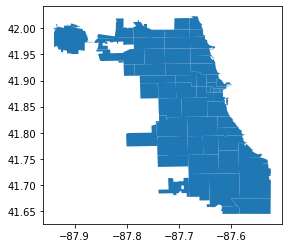

In [10]:
# view simple plot of chicago zip codes dataset

chi_zip_codes.plot();

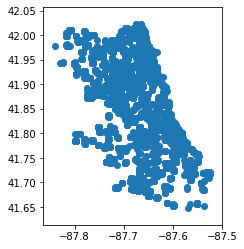

In [11]:
# view simple plot of chicago zip codes dataset

chi_parks_gdf.plot();

<a id="edit_shp"></a>
### Edit Shapefiles for Plotting

Next we will make some adjustments to the shapefiles to prepare to plot. We will make sure the spatial information is in the needed format and add some columns to allow for plotting.

#### Adjust coordinate reference

For everything to plot correctly, we need the coordinate reference system (CRS) for each geospatial data source to be the same. Additionally, since we will be plotting over external map tiles, we need the CRS to be the Web Mercator projection (epsg: 3857). Common reference systems can be found [here](https://epsg.io/?q=).

In [12]:
# display current CRS

zip_CRS = chi_zip_codes.crs
park_CRS = chi_parks_gdf.crs

print(zip_CRS)
print(park_CRS)

epsg:4326
epsg:4326


In [13]:
# convert to web mercator (epsg=3857) for tile mapping

chi_zip_codes = chi_zip_codes.to_crs(epsg=3857)
chi_parks_gdf = chi_parks_gdf.to_crs(epsg=3857)

zip_CRS = chi_zip_codes.crs
park_CRS = chi_parks_gdf.crs

print(zip_CRS)
print(park_CRS)

epsg:3857
epsg:3857


#### Add a point color column to the parks dataset

We will add a column that has a different color to the parks dataset depending on whether the park location is indoor or outdoor. `np.where` is a filtering function that returns data depending on a condition. In this case, the function returns `red` if the facility type is `OUTDOOR`, or `blue` for anything else.

For more info refer to the `np.where` docs [here](https://numpy.org/doc/stable/reference/generated/numpy.where.html).

In [14]:
# create an array of color values based on facility types

np.where(chi_parks_gdf['facility_t'] == 'OUTDOOR', 'red', 'blue')

array(['blue', 'blue', 'red', ..., 'red', 'red', 'blue'], dtype='<U4')

The above code created an array but didn't add it to the parks geodataframe. The next cell assigns the array to the `chi_parks_gdf` dataframe, creating a new column called `pt_color`.

In [15]:
# color outdoor parks red, everything else blue

chi_parks_gdf['pt_color'] = np.where(chi_parks_gdf['facility_t']
                                     == 'OUTDOOR', 'red', 'blue')

In [16]:
# view the updated dataframe

chi_parks_gdf.head()

,facility_n,facility_t,gisobjid,objectid,park,park_no,x_coord,y_coord,geometry,pt_color
0,CULTURAL CENTER,SPECIAL,2494.0,1066.0,HAMILTON (ALEXANDER),9.0,-87.637698,41.762999,POINT (-9755783.874 5125543.723),blue
1,GYMNASIUM,INDOOR,2495.0,1067.0,HAMILTON (ALEXANDER),9.0,-87.637929,41.762817,POINT (-9755809.634 5125516.459),blue
2,BASEBALL JR/SOFTBALL,OUTDOOR,2496.0,1068.0,HAMILTON (ALEXANDER),9.0,-87.636914,41.760849,POINT (-9755696.597 5125222.888),red
3,BASEBALL JR/SOFTBALL,OUTDOOR,2497.0,1069.0,HAMILTON (ALEXANDER),9.0,-87.638320,41.762005,POINT (-9755853.171 5125395.401),red
4,BASEBALL JR/SOFTBALL,OUTDOOR,2498.0,1070.0,HAMILTON (ALEXANDER),9.0,-87.638059,41.760474,POINT (-9755824.121 5125166.843),red


#### Get a count of the parks in each zip code

It is often useful to summarize one spatial data file by how it is spatially connected to another. In this case, we want to know how many park facilities are in each zip code. We can do this using a spatial join (gpd.sjoin). More information about merging data based on space and attributes can be found [here](https://geopandas.org/docs/user_guide/mergingdata.html)

In [17]:
# create a temporary geodataframe with spatial join

points_in_polygon = gpd.sjoin(chi_parks_gdf, chi_zip_codes, how="inner", op='intersects')
points_in_polygon['count']=1

Notice the resulting dataframe has attributes from both the parks and the zip codes datasets, but only one `geometry` column.

In [18]:
# preview data frame

points_in_polygon.head()

,facility_n,facility_t,gisobjid,objectid_left,park,park_no,x_coord,y_coord,geometry,pt_color,index_right,objectid_right,shape_area,shape_len,zip,count
0,CULTURAL CENTER,SPECIAL,2494.0,1066.0,HAMILTON (ALEXANDER),9.0,-87.637698,41.762999,POINT (-9755783.874 5125543.723),blue,10,9.0,1.047468e+08,42299.920391,60621,1
1,GYMNASIUM,INDOOR,2495.0,1067.0,HAMILTON (ALEXANDER),9.0,-87.637929,41.762817,POINT (-9755809.634 5125516.459),blue,10,9.0,1.047468e+08,42299.920391,60621,1
2,BASEBALL JR/SOFTBALL,OUTDOOR,2496.0,1068.0,HAMILTON (ALEXANDER),9.0,-87.636914,41.760849,POINT (-9755696.597 5125222.888),red,10,9.0,1.047468e+08,42299.920391,60621,1
3,BASEBALL JR/SOFTBALL,OUTDOOR,2497.0,1069.0,HAMILTON (ALEXANDER),9.0,-87.638320,41.762005,POINT (-9755853.171 5125395.401),red,10,9.0,1.047468e+08,42299.920391,60621,1
4,BASEBALL JR/SOFTBALL,OUTDOOR,2498.0,1070.0,HAMILTON (ALEXANDER),9.0,-87.638059,41.760474,POINT (-9755824.121 5125166.843),red,10,9.0,1.047468e+08,42299.920391,60621,1


Now you can group all the points by zip code.

In [19]:
# create a temporary geodataframe with spatial join grouped by zip code

new_df = gpd.GeoDataFrame(points_in_polygon.groupby(['zip']).sum()['count'])

In [20]:
# preview data frame

new_df.head()

,count
zip,
60601,4
60602,11
60603,1
60604,1
60605,50


Finally, we can join the mini `new_df` to the existing zip codes data set.

In [21]:
# combine dataframe with counts with zip codes data frame

zip_with_pk_ct = chi_zip_codes.merge(new_df, on='zip')

Now each of the zip code rows contains a count of how many park facilities are within the zip code.

In [22]:
# preview updated data frame

zip_with_pk_ct.head()

,objectid,shape_area,shape_len,zip,geometry,count
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-9760228.181 5148667.912, -9760226.5...",72
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-9765706.326 5149399.264, -9765717.1...",103
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-9772181.764 5147379.934, -9772215.9...",11
3,51.0,3.450671e+06,7909.890407,60707,"POLYGON ((-9774588.623 5151174.579, -9774614.5...",11
4,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-9759053.446 5144344.509, -9759053.4...",94


<a id="set_up_map1"></a>
### Set Up the Map

Now we can start setting up the first map. We first need to set the two geodataframes as sources for Bokeh.

In [23]:
# set bokeh data sources

parks_source = GeoJSONDataSource(geojson=chi_parks_gdf.to_json())
zips_source = GeoJSONDataSource(geojson=zip_with_pk_ct.to_json())

Now we will set some graphics settings. The `tile_provider` determines what tile set is used for the background. `Brewer` is a handy collection of color palettes.

In [24]:
# set graphics settings

tile_provider = get_provider(Vendors.OSM)  # for tile background

palette = list(brewer['OrRd'][8]) # for zip code colors
palette.reverse()
vals = zip_with_pk_ct['count']
color_mapper = LinearColorMapper(palette = palette,
                                       low = vals.min(), high = vals.max())
color_bar = ColorBar(color_mapper=color_mapper,
                           label_standoff=8, width=500, height=20,
                           location=(0,0), orientation='horizontal')

Now we will set up the first map window.

In [25]:
# Set up first sub map

s1 = figure(title="Park Map", plot_width=500, 
            x_range=(-9800000, -9740000), y_range=(5100000, 5170000))

# add zip code boundaries
s1.patches('xs', 'ys', source=zips_source, legend_label='zip codes',
           fill_alpha=0.0, line_color='black')

# add park points
s1.circle(x='x', y='y', source=parks_source, legend_label='parks', size=5, 
          color='pt_color', name="park_pts")

# add a tooltip for parks
hover = HoverTool(tooltips=[("park type", "@facility_n")], names=["park_pts"])
s1.add_tools(hover)

s1.legend.location = "top_right"
s1.legend.click_policy="hide" # hide the contents if you click the legend

Now we will set up the second map window.

In [26]:
# Set up second sub map

# the x_range and y_range make so that panning and zooming
# the maps will show the same extent
s2 = figure(title="Park Count Map", plot_width=500, x_range=s1.x_range, y_range=s1.y_range, 
            tooltips=[("zip code", "@zip"),("count", "@count")])

# add background tiles
s2.add_tile(tile_provider)

# add zip codes
s2.patches('xs', 'ys', source=zips_source, legend_label='zip codes',
           fill_alpha=0.8, line_color='grey',
           fill_color={'field' :'count' , 'transform': color_mapper})
s2.legend.location = "top_right"

In [27]:
# display map

p = layout(row(s1, s2), sizing_mode="stretch_width")
show(p)

<a id="more_interact"></a>
## A More Interactive Map

Now we will go through an example with more interaction. This map will use the 2018 Movies dataset.

<a id="load_movies"></a>
### Load and Edit Movies Dataset

The Summer Movies Dataset is stored in a `.csv` file. We can read it in a similar fashion to how we read the other shapefiles this time using the `pandas` library.

In [28]:
# read movies csv

movie_fp = r'movies_2018.csv'
movie_df = pd.read_csv(movie_fp)

In [29]:
# preview movies dataset

movie_df.head()

,Day,Date,Park,Park Phone,Title,CC,Rating,Underwriter,Park Address,Location
0,Sun,08/05/2018,Hamilton Park,(312) 747-6174,Black Panther,Y,PG-13,NaN,513 W. 72nd St.,"513 W. 72nd St.\nChicago, IL\n(41.763495, -87...."
1,Fri,06/15/2018,Vittum Park,(773) 284-6022,Justice League,Y,PG-13,NaN,5010 W. 50th St.,"5010 W. 50th St.\nChicago, IL\n(41.802024, -87..."
2,Sun,07/22/2018,Bessemer Park,(312) 747-6023,Star Wars: The Last Jedi,Y,PG-13,NaN,8930 S. Muskegon Ave.,"8930 S. Muskegon Ave.\nChicago, IL\n(41.732921..."
3,Thu,06/21/2018,Osterman Beach,(312) 742-1134,Donkey Skin (Peau d'ane),Y,NR,The Cultural Services at the Consulate General...,5800 N. Lake Shore Dr.,"5800 N. Lake Shore Dr.\nChicago, IL"
4,Thu,06/21/2018,Altgeld Park,(312) 746-5001,Justice League,Y,PG-13,NaN,515 S. Washtenaw Ave.,"515 S. Washtenaw Ave.\nChicago, IL\n(41.874341..."


#### Clean Location column

Our first task is to get the location column prepared to work with. Right now the street address and latitude and longitude values are mixed in one cell. We can work to select the correct data using python list comprehensions. We would like to create two new columns with just the latitude and just the longitude values.

In [30]:
# first - select data in the Location column

[loc for loc in movie_df['Location']][0:5]

['513 W. 72nd St.\nChicago, IL\n(41.763495, -87.637669)',
 '5010 W. 50th St.\nChicago, IL\n(41.802024, -87.748205)',
 '8930 S. Muskegon Ave.\nChicago, IL\n(41.732921, -87.555452)',
 '5800 N. Lake Shore Dr.\nChicago, IL',
 '515 S. Washtenaw Ave.\nChicago, IL\n(41.874341, -87.693699)']

In [31]:
# second - split by new line

[loc.split("\n") for loc in movie_df['Location']][0:5]

[['513 W. 72nd St.', 'Chicago, IL', '(41.763495, -87.637669)'],
 ['5010 W. 50th St.', 'Chicago, IL', '(41.802024, -87.748205)'],
 ['8930 S. Muskegon Ave.', 'Chicago, IL', '(41.732921, -87.555452)'],
 ['5800 N. Lake Shore Dr.', 'Chicago, IL'],
 ['515 S. Washtenaw Ave.', 'Chicago, IL', '(41.874341, -87.693699)']]

In [32]:
# third - select coordinates if present

[loc.split("\n")[2] if len(loc.split("\n")) > 2 else None 
 for loc in movie_df['Location']][0:5]

['(41.763495, -87.637669)',
 '(41.802024, -87.748205)',
 '(41.732921, -87.555452)',
 None,
 '(41.874341, -87.693699)']

In [33]:
# fourth - split coordinates

[loc.split("\n")[2].split(", ") if len(loc.split("\n")) > 2 else None
 for loc in movie_df['Location']][0:5]

[['(41.763495', '-87.637669)'],
 ['(41.802024', '-87.748205)'],
 ['(41.732921', '-87.555452)'],
 None,
 ['(41.874341', '-87.693699)']]

In [34]:
# fifth - select 1st coordinate

[loc.split("\n")[2].split(", ")[0] if len(loc.split("\n")) > 2 else None
 for loc in movie_df['Location']][0:5]

['(41.763495', '(41.802024', '(41.732921', None, '(41.874341']

In [35]:
# sixth - trim '(' and convert to float

[float(loc.split("\n")[2].split(", ")[0][1:]) if len(loc.split("\n")) > 2 else None
 for loc in movie_df['Location']][0:5]

[41.763495, 41.802024, 41.732921, None, 41.874341]

In [36]:
# do the same for longitude

[float(loc.split("\n")[2].split(", ")[1][:-1]) if len(loc.split("\n")) > 2 else None
 for loc in movie_df['Location']][0:5]

[-87.637669, -87.748205, -87.555452, None, -87.693699]

Now that we have selected the coordinates, we need to add them to the dataframe.

In [37]:
# add latitude values

movie_df['lat'] = [float(loc.split("\n")[2].split(", ")[0][1:])
                   if len(loc.split("\n")) > 2 else None
                   for loc in movie_df['Location']]

In [38]:
# add longitude values

movie_df['lon'] = [float(loc.split("\n")[2].split(", ")[1][:-1])
                   if len(loc.split("\n")) > 2 else None
                   for loc in movie_df['Location']]

In [39]:
# see the updated dataframe

movie_df.head()

,Day,Date,Park,Park Phone,Title,CC,Rating,Underwriter,Park Address,Location,lat,lon
0,Sun,08/05/2018,Hamilton Park,(312) 747-6174,Black Panther,Y,PG-13,NaN,513 W. 72nd St.,"513 W. 72nd St.\nChicago, IL\n(41.763495, -87....",41.763495,-87.637669
1,Fri,06/15/2018,Vittum Park,(773) 284-6022,Justice League,Y,PG-13,NaN,5010 W. 50th St.,"5010 W. 50th St.\nChicago, IL\n(41.802024, -87...",41.802024,-87.748205
2,Sun,07/22/2018,Bessemer Park,(312) 747-6023,Star Wars: The Last Jedi,Y,PG-13,NaN,8930 S. Muskegon Ave.,"8930 S. Muskegon Ave.\nChicago, IL\n(41.732921...",41.732921,-87.555452
3,Thu,06/21/2018,Osterman Beach,(312) 742-1134,Donkey Skin (Peau d'ane),Y,NR,The Cultural Services at the Consulate General...,5800 N. Lake Shore Dr.,"5800 N. Lake Shore Dr.\nChicago, IL",NaN,NaN
4,Thu,06/21/2018,Altgeld Park,(312) 746-5001,Justice League,Y,PG-13,NaN,515 S. Washtenaw Ave.,"515 S. Washtenaw Ave.\nChicago, IL\n(41.874341...",41.874341,-87.693699


Finally we want to remove records without coordinates.

In [40]:
# Remove null coordinate values

movie_df = movie_df[movie_df['lat'].notnull()]

#### Add timestamp

Now we want to add another column that translates the date to a date timestamp. This will be used when interacting with date sliders in our final map.

In [41]:
# add timestamp column 

movie_df['timestamp'] = [datetime.timestamp(datetime.strptime(date, '%m/%d/%Y'))
                          for date in movie_df['Date']]

#### Add rating color column

This column will be used to set the default color for our rating interaction.

In [42]:
# add base rating color column 

movie_df['rat_color'] = 'blue'

#### Convert to GeoDataFrame and add coordinate reference

Now we have coordinates isolated, we want to transform this dataframe to a GeoDataFrame.

In [43]:
# transform to geodataframe

movie_gdf = gpd.GeoDataFrame(movie_df,
                             geometry=gpd.points_from_xy(movie_df.lon, movie_df.lat))

In [44]:
# see the updated geodataframe

movie_gdf.head()

,Day,Date,Park,Park Phone,Title,CC,Rating,Underwriter,Park Address,Location,lat,lon,timestamp,rat_color,geometry
0,Sun,08/05/2018,Hamilton Park,(312) 747-6174,Black Panther,Y,PG-13,NaN,513 W. 72nd St.,"513 W. 72nd St.\nChicago, IL\n(41.763495, -87....",41.763495,-87.637669,1.533427e+09,blue,POINT (-87.63767 41.76349)
1,Fri,06/15/2018,Vittum Park,(773) 284-6022,Justice League,Y,PG-13,NaN,5010 W. 50th St.,"5010 W. 50th St.\nChicago, IL\n(41.802024, -87...",41.802024,-87.748205,1.529021e+09,blue,POINT (-87.74820 41.80202)
2,Sun,07/22/2018,Bessemer Park,(312) 747-6023,Star Wars: The Last Jedi,Y,PG-13,NaN,8930 S. Muskegon Ave.,"8930 S. Muskegon Ave.\nChicago, IL\n(41.732921...",41.732921,-87.555452,1.532218e+09,blue,POINT (-87.55545 41.73292)
4,Thu,06/21/2018,Altgeld Park,(312) 746-5001,Justice League,Y,PG-13,NaN,515 S. Washtenaw Ave.,"515 S. Washtenaw Ave.\nChicago, IL\n(41.874341...",41.874341,-87.693699,1.529539e+09,blue,POINT (-87.69370 41.87434)
5,Thu,08/16/2018,West Pullman Park,(312) 747-7090,The Fate of the Furious,Y,PG-13,NaN,401 W. 123rd St.,"401 W. 123rd St.\nChicago, IL\n(41.670629, -87...",41.670629,-87.632400,1.534378e+09,blue,POINT (-87.63240 41.67063)


Now we need to set the coordinate reference information for this dataset. If we look at the CRS, it is set to `None` at first. We know this data set is using latitude and longitude values, so we set the CRS to "EPSG:4326". Once it is set, we can transform it to the Web Mercator reference.

In [45]:
# set and change CRS

movie_CRS = movie_gdf.crs
print(movie_CRS)

movie_gdf.crs = "EPSG:4326"
movie_CRS = movie_gdf.crs
print(movie_CRS)

movie_gdf = movie_gdf.to_crs(epsg=3857)

None
EPSG:4326


<a id="create_tl_dataset"></a>
### Create New Timeline Dataset

Now we will create a new dataframe entirely from scratch. We will add a small example with a date, some notes, and an optional image file name.

In [46]:
# create the timeline base array

tl_data = [['06/15/2018', 'Saw Back to the Future with Jan!', "Back_to_the_Future.jpeg"], 
           ['07/22/2018', "Movie rained out", ""], 
           ['09/16/2018', "Caught the Last movie", ""]]

In [47]:
# convert the timeline dataset to a dataframe

tl_df = pd.DataFrame(tl_data, columns = ['tl_date', 'tl_note', 'tl_image'])

In [48]:
# create a timestamp column from the date
# multiply by 1000 to translate to the correct number of seconds in the timestamp

tl_df['tl_ts'] = [datetime.timestamp(datetime.strptime(date, '%m/%d/%Y'))*1000 
                  for date in tl_df['tl_date']]

In [49]:
# view the resulting dataframe

tl_df.head()

,tl_date,tl_note,tl_image,tl_ts
0,06/15/2018,Saw Back to the Future with Jan!,Back_to_the_Future.jpeg,1.529021e+12
1,07/22/2018,Movie rained out,,1.532218e+12
2,09/16/2018,Caught the Last movie,,1.537056e+12


<a id="set_up_map2"></a>
### Set Up the Map

Now we will set up the map! First we will register our datasources and tile provider.

In [50]:
# record data sources for bokeh

movie_source = GeoJSONDataSource(geojson=movie_gdf.to_json())
movie_disp_source = GeoJSONDataSource(geojson=movie_gdf.to_json())
timeline_source = ColumnDataSource(tl_df)

In [51]:
# set tile provider

tile_provider2 = get_provider(Vendors.CARTODBPOSITRON)

Now we will set up the first sub map. This map will show park points. When you hover over a point you will see the movie titles that are showing.

In [52]:
# set up first sub map (park points map)

s4 = figure(title="Movie Map", plot_width=500, 
            x_range=(-9800000, -9740000), y_range=(5100000, 5170000),
           tooltips=[("", "@Title")], tools="tap")
s4.toolbar.logo = None
s4.toolbar_location = None
s4.add_tile(tile_provider2)

# plot points for movie locations
mov_pts = s4.circle(x='x', y='y', source=movie_disp_source, fill_color='rat_color',
                    legend_label='movies', size=5)

Next we will add a dropdown widget. This widget will change the color of the points when `Rating` is selected. This introduces the JavaScript based callback. When the a new value is selected in the dropdown, the `callback_p` Javascript is re evaluated and changes the map contents.

In [53]:
# add a dropdown menu to change the point color 

menu = [("Default", "default"), ("Rating", "rating")]

callback_p = CustomJS(args = dict(source = movie_source, 
                                  fill_source = movie_disp_source, 
                                  s4=s4, mov_pts=mov_pts), 
                         code = """
var data = source.data;
var fill_data = fill_source.data;
var choice =  this.item;

if (choice == "rating") {
    fill_data['rat_color'] = [];
    
    for (var i = 0; i < data.x.length; i++) { 
    
        if (fill_data['Rating'][i] == "PG-13") {
            fill_data['rat_color'].push('red');
        } else {
            fill_data['rat_color'].push('yellow');
        }  
    }
    mov_pts.glyph.fill_color.field = 'rat_color';
} else {
    mov_pts.glyph.fill_color = 'blue';
}

fill_source.change.emit();
    """)

dropdown = Dropdown(label="Change Point Color", button_type="warning", menu=menu)
dropdown.js_on_event("menu_item_click", callback_p)


Next we will add a date slider to be able to select a date range. This will also call a callback function to change which points are displayed when the slider is changed.

In [54]:
# add a data range slider

callback_t = CustomJS(args = dict(source = movie_source, fill_source = movie_disp_source), 
                         code = """
var data = source.data;
var fill_data = fill_source.data;
var s_val = cb_obj.value;
fill_data['x']=[];
fill_data['y']=[];
for (var i = 0; i < data.x.length; i++) { 
    if ((data['timestamp'][i] >= (s_val[0]/1000)) 
    && (data['timestamp'][i] <= (s_val[1]/1000))) {
        fill_data['y'].push(source.data['y'][i]);
        fill_data['x'].push(source.data['x'][i]);
    } else {
        fill_data['y'].push(NaN);
        fill_data['x'].push(NaN);
    }
    }

fill_source.change.emit();
""")

date_range_slider = DateRangeSlider(value=(date(2018, 6, 1), date(2018, 8, 1)),
                                    start=date(2018, 5, 1), end=date(2018, 10, 1))
date_range_slider.js_on_change("value", callback_t)

Now we will add a `div`. This is an HTML placeholder that stores text.

In [55]:
# this is a placeholder to display text interactively 

div = Div(text="""""", width=200, height=100)

Now we will add a `taptool`. This function changes the display if a point is selected. In this example, text will be placed in the div when a point is selected.

In [56]:
# add tap tool to display text when point is selected

taptool = s4.select(type=TapTool)
taptool.callback =  CustomJS(args = dict(source = movie_disp_source, div = div), 
 code = """
     var data = source.data;
     const inds = source.selected.indices;
     var base_str = "";
     for (const indx in inds) {
         base_str = base_str.concat('id: ', inds[indx].toString(), '<br />');
         base_str = base_str.concat('date: ', data['Date'][inds[indx]], '<br />');
         base_str = base_str.concat('title: ', data['Title'][inds[indx]], '<br />');
         base_str = base_str.concat('rating: ', data['Rating'][inds[indx]], '<br />');
         base_str = base_str.concat('park: ', data['Park'][inds[indx]], '<br />');
         if (data['Title'][inds[indx]] == "Back to the Future") {
             base_str = base_str.concat('<img src="Back_to_the_Future.jpeg">');
         }
         base_str = base_str.concat('<hr>');
     }
     div.text = base_str;
                             
""")


tl_hover = HoverTool(
        tooltips="""
    <div>
        <div>
            <img
                src="@tl_image" height="42" width="42"
                style="float: left; margin: 0px 15px 15px 0px;"
                onerror="this.style.display='none'"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@tl_date</span>
            <br>
            <span style="font-size: 15px; color: #966;">@tl_note</span>
        </div>
    </div>
        """)

Now we will create a "timeline" type map. This will be a one-dimensional chart that will show information when you hover over a point.

In [57]:
# create timeline figure

s5 = figure(title="Timeline", x_axis_type='datetime',  tools=[tl_hover],
            plot_height=100,
            # multiply x range by 1000 to convert between microseconds
           x_range=(datetime.timestamp(datetime.strptime('06/01/2018', '%m/%d/%Y'))*1000, 
                    datetime.timestamp(datetime.strptime('8/01/2018', '%m/%d/%Y'))*1000),
            y_range=(0.5, 1.5))
s5.yaxis.major_label_text_font_size = '0pt'
s5.toolbar.logo = None
s5.toolbar_location = None
tl_pts = s5.triangle_pin(x='tl_ts', y=1, source=timeline_source, fill_color='blue', size=20)


Next we will link the values of the date range slider and the timeline. This means that when you change the value in the date range slider you will change what points are displayed on the map and on the timeline.

In [58]:
# link timeline and date range slider

date_range_slider.js_link('value', s5.x_range, 'start', attr_selector=0)
date_range_slider.js_link('value', s5.x_range, 'end', attr_selector=1)

Finally we will show the map! Note: The `notebook_handle=True` setting is extremely important and must be `True` for the interaction to work properly.

In [59]:
# show the final map

t = show((column(row(s4, div), dropdown, date_range_slider, s5)), notebook_handle=True)

Now interact with the map and see what happens!
- Hover over a point. 
- Click on a point. Make sure to check out and click on `Back to the Future` showing at `Oaks Park` near the tile label for `Park Ridge` to the far NW of the dataset.
- Change the point color using the dropdown button
- Move the date slider and look at the timeline and the map points
- Hover over the points on the timeline.

Hopefully this tutorial has provided some tips for your own interactive mapping projects!